# Librerie e funzioni d'utilità

In [1]:
import os
import wfdb as wf
import numpy as np
from matplotlib import pyplot as plt

In [2]:
channel = 0             # There are 2 channels
sample_start = 0        # Start of the sample in the file.
sample_size = 4000      # Number of readings (360 per second).

In [3]:
directory_dataset = ".\\mitdb"

In [4]:
# Se non esiste, crea cartella mitdb e scarica il dataset
if not os.path.exists(directory_dataset):
    os.mkdir(directory_dataset)
    wfdb.dl_database("mitdb", directory_dataset)

# wfdb.io.show_ann_classes()
# wfdb.io.show_ann_labels()

# Plot ECG

In [5]:
list_of_file = list(set([x.rsplit('.', 1)[0] for x in os.listdir(directory_dataset)]))
list_of_file.sort()

In [6]:
for filename in list_of_file:
    file = os.path.join(directory_dataset, filename)
    
    # Read the file.
    record = wf.rdsamp("mitdb//100")
    annotation = wf.rdann("mitdb//100", 'atr')

    # Info about the data.
    print('Sampling frequency:', record[1].get('fs'))
    print('Data shape:', record[0].shape)
    print('Annotations:', len(annotation.num))
    break

Sampling frequency: 360
Data shape: (650000, 2)
Annotations: 2274


In [7]:
record[0]

array([[-0.145, -0.065],
       [-0.145, -0.065],
       [-0.145, -0.065],
       ...,
       [-0.675, -0.365],
       [-0.765, -0.335],
       [-1.28 ,  0.   ]])

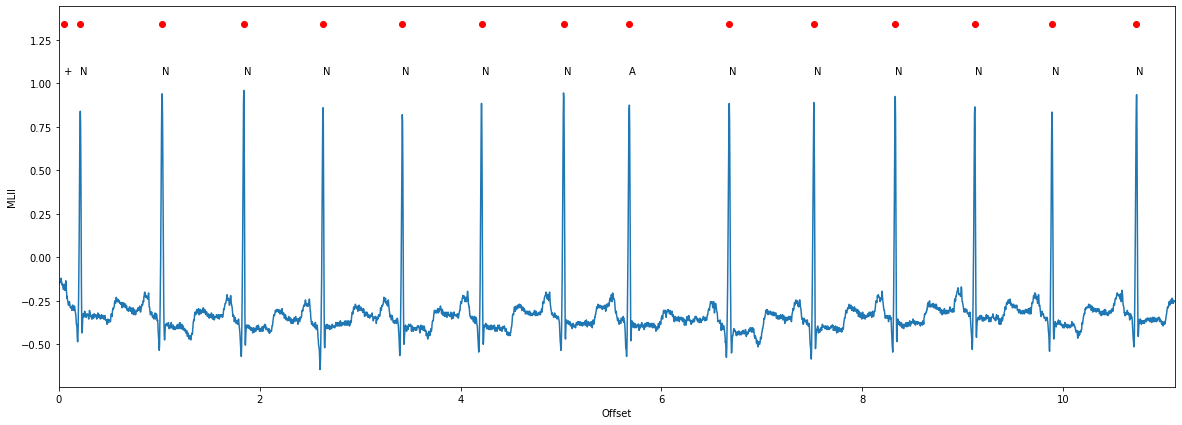

In [92]:
# record = wf.rdsamp("mitdb//100")
# annotation = wf.rdann("mitdb//100", 'atr')

# Get data and annotations for the samples selected below.
sample_end = sample_start + sample_size
signal = record[0][sample_start:sample_end, channel]

# Plot the heart beats. Time scale is number of readings
# divided by sampling frequency.
times = (np.arange(sample_size, dtype = 'float') + sample_start) / record[1].get('fs')
plt.figure(figsize=(20,7))
plt.plot(times, signal)

# Extract annotations.
where = np.logical_and(annotation.sample >= sample_start, annotation.sample < sample_end)
annots = annotation.sample[where] - sample_start
annotypes = np.array(annotation.symbol)
annotypes = annotypes[where]

# Plot the Annotations.
annotimes = times[annots]
plt.plot(annotimes, np.ones_like(annotimes) * signal.max() * 1.4, 'ro')

# Annotation codes.
for idx, annot in enumerate(annots):
    plt.annotate(annotypes[idx], xy = (times[annot], signal.max() * 1.1))

plt.xlim([sample_start / record[1].get('fs'), (sample_end / record[1].get('fs'))])
plt.xlabel('Offset')
plt.ylabel(record[1].get('sig_name')[channel])
plt.show()